### 수정로그

2025/7/14 전체 파라미터 수를 50,000으로 제한

# 제1회 퀀텀AI 경진대회 베이스라인


이 안내 노트북에서는 양자 컴퓨팅 프레임 워크에 대한 개략적인 소개와 QML의 구현 방법을 알아 봅니다.


다양한 QML framework가 있고 기존 ML framework들과 잘 통합되어 있습니다.
일반적으로는 다음 2 개를 많이 사용합니다.

1. Pennylane: 캐나다 Xanadu에서 만든 양자 컴퓨팅 Framework입니다. 다른 프로젝트들에 비해 머신러닝에 친화적인 인터페이스와 요소를 제공합니다.
2. Qiskit: IBM에서 만든 양자컴퓨팅 Framework입니다. 좀 더 물리적인 실험과 및 대규모 HPC 연산을 포함하는 통합적인 Framework를 제공하고 있습니다.

여기서는 QML 구현을 위해 Pennylane을 사용해 볼 것입니다.

Pennylane은 PyPI에 등록되어 있습니다. 현재 최신 버전은 0.4.x입니다.
다음 명령어로 Python 환경에 `pennylane`을 설치하세요.

Pennylane에 대한 Tutorial과 자세한 사항들은 [Pennylane codebook](https://pennylane.ai/codebook)과 [Demos](https://pennylane.ai/search/?contentType=DEMO&categories=how-to&sort=publication_date) 를 참고하세요.

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 29.6 MB/s eta 0:00:00


## 양자 회로 설계하기

In [1]:
import pennylane as qml # 일반적으로 qml이란 이름으로 가져옵니다. Quantum Machine Learning의 약자입니다.
import numpy as np

dev = qml.device("default.qubit", wires=3) # device를 정의합니다.

@qml.qnode(dev)
def circuit():
    qml.H(0)
    qml.S(0)
    qml.H(1)
    qml.H(2)
    return qml.probs()

d:\miniconda3\Lib\site-packages\pennylane\__init__.py:196: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.0 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


## 양자 회로 그리기

In [2]:
print(qml.draw(circuit)())

0: ──H──S─┤  Probs
1: ──H────┤  Probs
2: ──H────┤  Probs


(<Figure size 500x400 with 1 Axes>, <Axes: >)

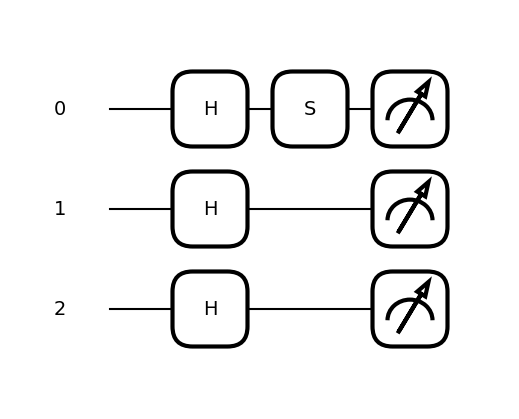

In [3]:
qml.draw_mpl(circuit)()

|양자 회로| ML|
|:--:|:--:|
|Quantum Circuit| Layer, ML Module|
|Backend | device(CPU, CUDA, ...)|

## Backend

Backend는 실제 양자 회로를 구동하는 시뮬레이터, 혹은 양자 컴퓨터입니다. 한 개의 회로를 어느 기기에서 돌릴 지 미리 선언을 해주어야 합니다.


**Backend 선택하기**

다양한 Backend를 양자 회로를 돌리는 데 사용할 수 있습니다. Pennylaned의 `default.qubit`, `lightning.qubit`등 뿐만 아니라, Qiskit, IQM 등 실제 양자 컴퓨터의 Backend interface를 가져와 사용할 수도 있습니다.
그러나, QML을 구현하고 시험해 볼 때는 `default.qubit`이 권장됩니다. 다른 ML 프레임워크와의 결합도 간편할 뿐더러 가장 빠른 differentiation 방법을 제공합니다.

Backend 선택과 개별 device에 대한 정보는 Pennylane의 공식 문서: [Quantum Devices](https://pennylane.ai/devices)를 참고하세요.

In [4]:
NUMBER_OF_WIRES =20
dev = qml.device("default.qubit", wires=NUMBER_OF_WIRES, shots=3000)

## 측정하기

- `qml.probs`: 개별 state들의 측정 확률 벡터입니다. $N$ qubit에 대해 $2^N$ 크기를 가집니다.
- `qml.expval`: Pennylane의 Observable들을 측정합니다. 기초적으로 `qml.PauliZ(i), qml.PauliX(i), qml.PauliY(i)`가 있으며 이들을 조합 하거나/여러개의 Observable을 측정할 수 있습니다.

In [5]:
dev_3 = qml.device("default.qubit", wires=3)

@qml.qnode(dev_3)
def circuit1():
    qml.H(0)
    qml.H(1)
    return qml.expval(qml.PauliX(0))
@qml.qnode(dev_3)
def circuit2():
    qml.H(0)
    qml.H(1)
    return qml.probs()
@qml.qnode(dev_3)
def circuit3():
    qml.H(0)
    qml.H(1)
    return [qml.expval(qml.PauliZ(i)) for i in range(3)]


In [6]:
circuit1()

0.9999999999999996

In [7]:
circuit2()

array([0.25, 0.  , 0.25, 0.  , 0.25, 0.  , 0.25, 0.  ])

In [8]:
circuit3()

[0.0, 0.0, 0.9999999999999996]

In [9]:
obs = qml.PauliZ(0) @ qml.PauliX(1)
obs

Z(0) @ X(1)

In [10]:
@qml.qnode(dev_3)
def circuit4():
    qml.H(0)
    qml.H(1)
    qml.H(2)
    return qml.expval(obs)

In [11]:
circuit4()

0.0

## 양자 회로의 설계

In [12]:
from pennylane import numpy as np_p

In [13]:
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev)
def single_qubit_circuit(theta, input_value):
    qml.RX(theta, wires=0)
    qml.RY(input_value, wires=0)
    return qml.expval(qml.PauliZ(0))


In [14]:
single_qubit_circuit(0.1, 0.2) # Customized numpy result

0.9751703272018161

In [15]:
#Batched data
theta = 0.032
theta_b = np_p.array([0.2, 0.3, 0.5])
input_value_b = np_p.array([3.2, 1.2, 0.1])


In [16]:
single_qubit_circuit(theta_b, input_value_b) # Parameter가 모두 Batched parameter

tensor([-0.97839534,  0.34617358,  0.8731983 ], requires_grad=True)

In [17]:
single_qubit_circuit(theta, input_value_b) # Single, batched parameter 조합

tensor([-0.99778369,  0.36217224,  0.99449477], requires_grad=True)

#### Pennylane Optimizer

In [18]:
opt = qml.GradientDescentOptimizer(stepsize=0.01)
max_iterations = 500
conv_tol = 1e-06
param = np_p.random.rand(1, requires_grad=True)

his_param = []
his_energy = []
for i in range(max_iterations):
    param, prev_energy = opt.step_and_cost(lambda x: single_qubit_circuit(x, input_value_b[0]), param)
    his_param.append(param)
    his_energy.append(prev_energy)
    energy = single_qubit_circuit(param, input_value_b[0])
    conv = np_p.abs(prev_energy - energy)
    if conv <= conv_tol:
        break


In [19]:
import matplotlib.pyplot as plt

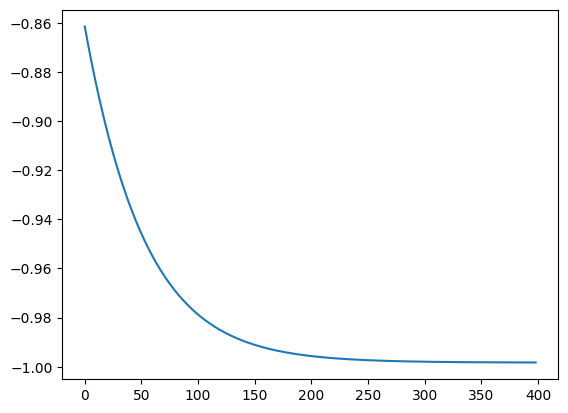

In [20]:
plt.plot(his_energy)

### Torch integration

In [21]:
import torch
from torch.optim import Adam
from torch.nn.parameter import Parameter
from torch.nn import NLLLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
print(device)

cuda


In [23]:
torch_theta = torch.rand(4)
torch_phi = torch.rand(4)
single_qubit_circuit(torch_theta, torch_phi) # Torch tensor의 경우 자동으로 tensor array로 변환

tensor([0.9953, 0.5190, 0.5808, 0.6999], dtype=torch.float64)

In [24]:
parameter = Parameter(torch.tensor( torch.rand(1).item(), requires_grad = True))
parameter

Parameter containing:
tensor(0.3794, requires_grad=True)

In [25]:
optim = Adam([parameter], lr= 0.001)

In [26]:
input_data = torch.rand(1)
history_e  =[]
for i in range(1000):
    optim.zero_grad()
    result = single_qubit_circuit(input_data, parameter)+1
    loss = (result)
    loss.backward()
    history_e.append(result.item())
    optim.step()

In [27]:
import matplotlib.pyplot as plt

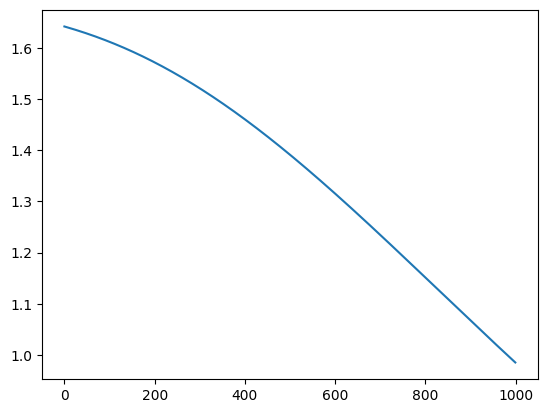

In [28]:
plt.plot(history_e)

# 분류 모델 만들기

## 0-1 binary classfiers

### Fashion MINIST dataset

In [29]:
import torch
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torchvision

In [30]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,))
        ])

train_ds = torchvision.datasets.FashionMNIST(
    "./", train=True, download=True,
    transform=transform)

test_ds = torchvision.datasets.FashionMNIST(
    "./", train=False, download=True,
    transform=transform)

In [31]:
train_mask = (train_ds.targets == 0) | (train_ds.targets == 6)
train_idx = torch.where(train_mask)[0]
train_ds.targets[train_ds.targets == 6] = 1

binary_train_ds = Subset(train_ds, train_idx)

In [32]:
train_loader = DataLoader(binary_train_ds, batch_size = 1, shuffle =True)

In [33]:
from matplotlib import pyplot as plt

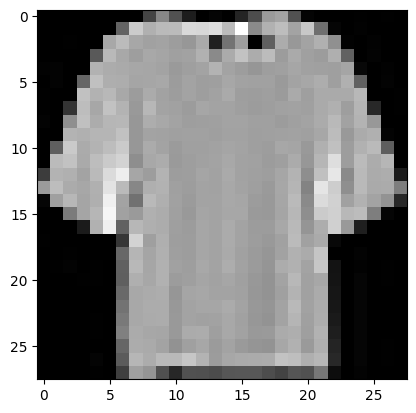

In [34]:
plt.imshow(binary_train_ds[20][0][0], cmap="grey")

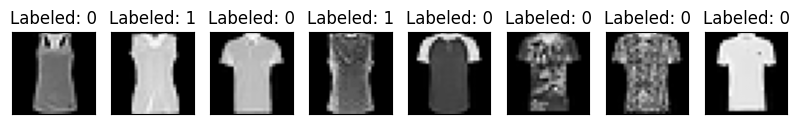

In [35]:
n_samples_show = 8

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [36]:
from torch.nn import Module
import torch.nn.functional as F
from torch.nn import Conv2d, Dropout2d, Linear
from torch import cat

In [37]:
torch.set_default_dtype(torch.float64)
class BinaryClassifier(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)
        self.fc3 = Linear(1, 1)

        # Quantum layer
        self.q_device = qml.device("default.qubit", wires=2)
        self.qnn_params = Parameter(torch.rand(8), requires_grad= True)
        self.obs = qml.PauliZ(0) @ qml.PauliZ(1)

        @qml.qnode(self.q_device)
        def circuit(x):
            qml.H(wires=0)
            qml.H(wires=1)

            qml.RZ(2.*x[0], wires=0)
            qml.RZ(2.*x[1], wires=0)

            qml.CNOT(wires=[0, 1])
            qml.RZ(2.*(torch.pi - x[0])*(torch.pi - x[1]), wires=1)
            qml.CNOT(wires=[0, 1])
            #------------------------------------------
            qml.RY(2.*self.qnn_params[0], wires=0)
            qml.RY(2.*self.qnn_params[1], wires=1)
            qml.CNOT(wires=[0, 1])
            qml.RY(2.*self.qnn_params[2], wires=0)
            qml.RY(2.*self.qnn_params[3], wires=1)
            qml.CNOT(wires=[1, 0])
            qml.RY(2.*self.qnn_params[4], wires=0)
            qml.RY(2.*self.qnn_params[5], wires=1)
            qml.CNOT(wires=[0, 1])
            qml.RY(2.*self.qnn_params[6], wires=0)
            qml.RY(2.*self.qnn_params[7], wires=1)

            return qml.expval(self.obs)

        self.qnn = circuit

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x).view(1,)  # apply QNN
        x = self.fc3(x)
        return F.log_softmax(cat((x, 1 - x), -1), -1)

In [38]:
bc = BinaryClassifier()

bc.to(device)

BinaryClassifier(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)

In [39]:
# prompt: bc의 전체 학습 가중치 파라미터 개수를 알라보려면? 영어로 출력

total_params = sum(p.numel() for p in bc.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")


Total number of trainable parameters: 17456


In [40]:
# ───── 학습 전에 회로 제약 먼저 점검 ─────
import pennylane as qml, torch

dummy_x = torch.tensor([0.0, 0.0], dtype=torch.float64)
specs = qml.specs(bc.qnn)(dummy_x)

In [41]:
specs

{'resources': Resources(num_wires=2, num_gates=18, gate_types=defaultdict(<class 'int'>, {'Hadamard': 2, 'RZ': 3, 'CNOT': 5, 'RY': 8}), gate_sizes=defaultdict(<class 'int'>, {1: 13, 2: 5}), depth=13, shots=Shots(total_shots=None, shot_vector=())),
 'errors': {},
 'num_observables': 1,
 'num_trainable_params': 8,
 'num_device_wires': 2,
 'num_tape_wires': 2,
 'device_name': 'default.qubit',
 'level': 'gradient',
 'gradient_options': {},
 'interface': 'auto',
 'diff_method': 'best',
 'gradient_fn': 'backprop'}

In [42]:
assert specs["num_tape_wires"] <= 8,  "❌ 큐빗 수 초과"
assert specs['resources'].depth <= 30, "❌ 회로 깊이 초과"
assert specs["num_trainable_params"]<= 60, "❌ 학습 퀀텀 파라미터 수 초과"
assert total_params <= 50000, "❌ 학습 전체 파라미터 수 초과"

print("✅ 회로 제약 통과 — 학습을 계속합니다")

✅ 회로 제약 통과 — 학습을 계속합니다


In [43]:
len(iter(train_loader))

12000

In [44]:
data, target = next(iter(train_loader))

In [45]:
optimizer = Adam(bc.parameters(), lr=0.0001)
loss_func  = NLLLoss()

epochs = 1
loss_history = []
bc.train()

BinaryClassifier(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)

In [46]:
data.shape

torch.Size([1, 1, 28, 28])

In [47]:
from tqdm import tqdm


for epoch in range(epochs):
    # 에폭 진행률 바
    epoch_bar = tqdm(range(len(train_loader)),
                     desc=f"Epoch {epoch+1}/{epochs}",
                     leave=False)   # leave=False면 다음 에폭 때 덮어씀

    total_loss = []
    for bidx, (data, target) in zip(epoch_bar, train_loader):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad(set_to_none=True)

        output = bc(data)
        loss   = loss_func(output, target.squeeze())

        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        # 100배치마다 postfix로 현재 상태 표시
        if bidx % 100 == 0:
            epoch_bar.set_postfix(batch=bidx,
                                  loss=f"{loss.item():.4f}")

    # 에폭 끝나면 전체 loss 기록
    avg_loss = sum(total_loss) / len(total_loss)
    loss_history.append(avg_loss)

    # 에폭 요약 한 줄 출력 (leave=False였으면 이게 마지막 줄로 남음)
    print(f"Training [{100.0 * (epoch+1)/epochs:.0f}%] "
          f"Loss: {avg_loss:.4f}")

Training [100%] Loss: 0.4741


# 모델 추론

In [48]:
from datetime import datetime

test_loader = DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False
)

bc.eval()

all_preds, all_targets = [], []

with torch.no_grad():
    for data, target in tqdm(test_loader,
                             desc="Inference",
                             total=len(test_loader),
                             leave=False):
        data, target = data.to(device), target.to(device)

        logits = bc(data)

        pred = logits.argmax().view(1)

        all_preds.append(pred.cpu())
        all_targets.append(target.view(-1).cpu())

y_pred = torch.cat(all_preds).numpy().astype(int)
y_true = torch.cat(all_targets).numpy().astype(int)

 # 평가 및 결과 저장

In [ ]:
# 0·6 라벨만 평가
test_mask = (y_true == 0) | (y_true == 6)

print("total samples:", len(y_true))
print("target samples:", test_mask.sum())

# 모델 결과가 1인 것을 6으로 변경
y_pred_mapped = np.where(y_pred == 1, 6, y_pred)

acc = (y_pred_mapped[test_mask] == y_true[test_mask]).mean()
print(f"accuracy (labels 0/6 only): {acc:.4f}")

# 현재 시각을 "YYYYMMDD_HHMMSS" 형식으로 포맷팅
now = datetime.now().strftime("%Y%m%d_%H%M%S")

# 원본 파일명을 기반으로 새 파일명 생성
y_pred_filename = f"y_pred_{now}.csv"

np.savetxt(y_pred_filename, y_pred_mapped, fmt="%d")

total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8200


: 

# 모델 추론 결과 파일 다운로드

자동으로 다운로드되는 파일을 [제출하기](https://aifactory.space/task/9154/submit) 페이지에 업로드하면 자동으로 채점이 되며 정상적으로 채점이 된다면 리더보드에서 자기점수를 확인할 수 있습니다.


In [71]:
from google.colab import files

files.download(y_pred_filename)

ModuleNotFoundError: No module named 'google.colab'